In [1]:
import time

import pandas as pd
import numpy as np

import tomotopy as tp
import pprint

import collections
import gensim
from konlpy.tag import  Komoran
from konlpy.corpus import kolaw

import matplotlib.pyplot as plt
import matplotlib.colors as clr


%matplotlib inline 


import matplotlib.font_manager as fm

fm.get_fontconfig_fonts()
fontpath = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=fontpath).get_name()
plt.rc('font', family=font_name)

%matplotlib inline

%config InlineBackend.figure_format = 'retina'



In [2]:
df = pd.read_csv("중복제거(진짜최종).csv", encoding='UTF-8')
동아df = df[df['Species'] == '동아']
경향df = df[df['Species'] == '경향']

In [3]:
def get_coherence(model, coherence=None, topn=None, processes=None):
    
    topics = []
    for k in range(model.k):
        word_probs = model.get_topic_words(k, topn)
        topics.append([word for word, prob in word_probs])
     
    texts = []
    corpus = []
    for doc in model.docs:
        words = [model.vocabs[token_id] for token_id in doc.words]
        texts.append(words)
        freqs = list(collections.Counter(doc.words).items())                  
        corpus.append(freqs)
    
    id2word = dict(enumerate(model.vocabs))
    dictionary = gensim.corpora.dictionary.Dictionary.from_corpus(corpus, id2word)
    
    cm = gensim.models.coherencemodel.CoherenceModel(
        topics=topics,
        texts=texts,
        corpus=corpus,
        dictionary=dictionary,  
        coherence=coherence,
        topn=topn,
        processes=processes,
    )

    return cm.get_coherence()

In [9]:
def compute_coherence_values(start, limit, step, content):
    starttime = time.time()
    for j in range(start, limit+1, step):
        remaintime = time.time()
        print(f"====={j}개짜리 토픽실행중... 실행중 포함 {int((limit-j)/step)+1} 경우의 수 남음=====")
                      
        mdl = tp.LDAModel(k=j)
        x = len(content)
        for i in range(0,len(content)):
            mdl.add_doc(content[i])           

        mdl.train(iter=50, workers=0)             
        
        coherence_value = get_coherence(mdl, coherence='c_v', topn=10, processes=5)

        print(f'Topic: {i}\tLog-likelihood: {mdl.ll_per_word}\tPerplexity: {mdl.perplexity}\tCoherence: {coherence_value}')
           
        coherence_values.append(coherence_value) 
        perplexities.append(mdl.perplexity)
        runtime = time.time() - remaintime
        if not int((limit-j)/step) == 0:
            print(f'남은 예상시간 : {runtime*int((limit-j)/step)}초')
        else:
            runtime = time.time() - starttime
            print(f"끝, {runtime}초걸림")

In [5]:
komoran = Komoran()
stopwords = ['때문','필요','지금','자신','부분','제공','이번','올해','이날','오후','지난해','최근','필요','경우','때문','경우','정도','비대','지난해','대비','올해','전년']
#ver1에서 찾은 stopwords를 그대로 차용

동아Content = []
경향Content = []

starttime = time.time()

for i in 동아df['Content']:
    morphs = komoran.nouns(i)
    pos = []

    for word in morphs:
        if not len(word) < 2:
            if word not in stopwords:
                pos.append(word)
    동아Content.append(pos)
    
runtime = time.time() - starttime
print(f"동아 형태소 분석 끝, {runtime}초걸림")

for i in 경향df['Content']:
    morphs = komoran.nouns(i)
    pos = []

    for word in morphs:
        if not len(word) < 2:
            if word not in stopwords:
                pos.append(word)
    경향Content.append(pos)
    
runtime = time.time() - starttime
print(f"경향 형태소 분석 끝, {runtime}초걸림")



동아 형태소 분석 끝, 184.03717160224915초걸림
경향 형태소 분석 끝, 301.56584763526917초걸림


* 동아, 경향의 적당한 k값 찾기

=====10개짜리 토픽실행중... 실행중 포함 19 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.394051015822482	Perplexity: 4420.689753931724	Coherence: 0.5700990501304115
남은 예상시간 : 486.785831451416초
=====15개짜리 토픽실행중... 실행중 포함 18 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.37956570872764	Perplexity: 4357.116257683653	Coherence: 0.5720126207591445
남은 예상시간 : 264.967568397522초
=====20개짜리 토픽실행중... 실행중 포함 17 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.366433326579628	Perplexity: 4300.271015601565	Coherence: 0.6011153796246039
남은 예상시간 : 441.61634826660156초
=====25개짜리 토픽실행중... 실행중 포함 16 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.366110008368862	Perplexity: 4298.880884410466	Coherence: 0.5977496289073382
남은 예상시간 : 386.67542695999146초
=====30개짜리 토픽실행중... 실행중 포함 15 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.354212527100911	Perplexity: 4248.038080003648	Coherence: 0.6215083358216732
남은 예상시간 : 276.5688533782959초
=====35개짜리 토픽실행중... 실행중 포함 14 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.345456326573256	Perplexity

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270985D03A0>,
      dtype=object)

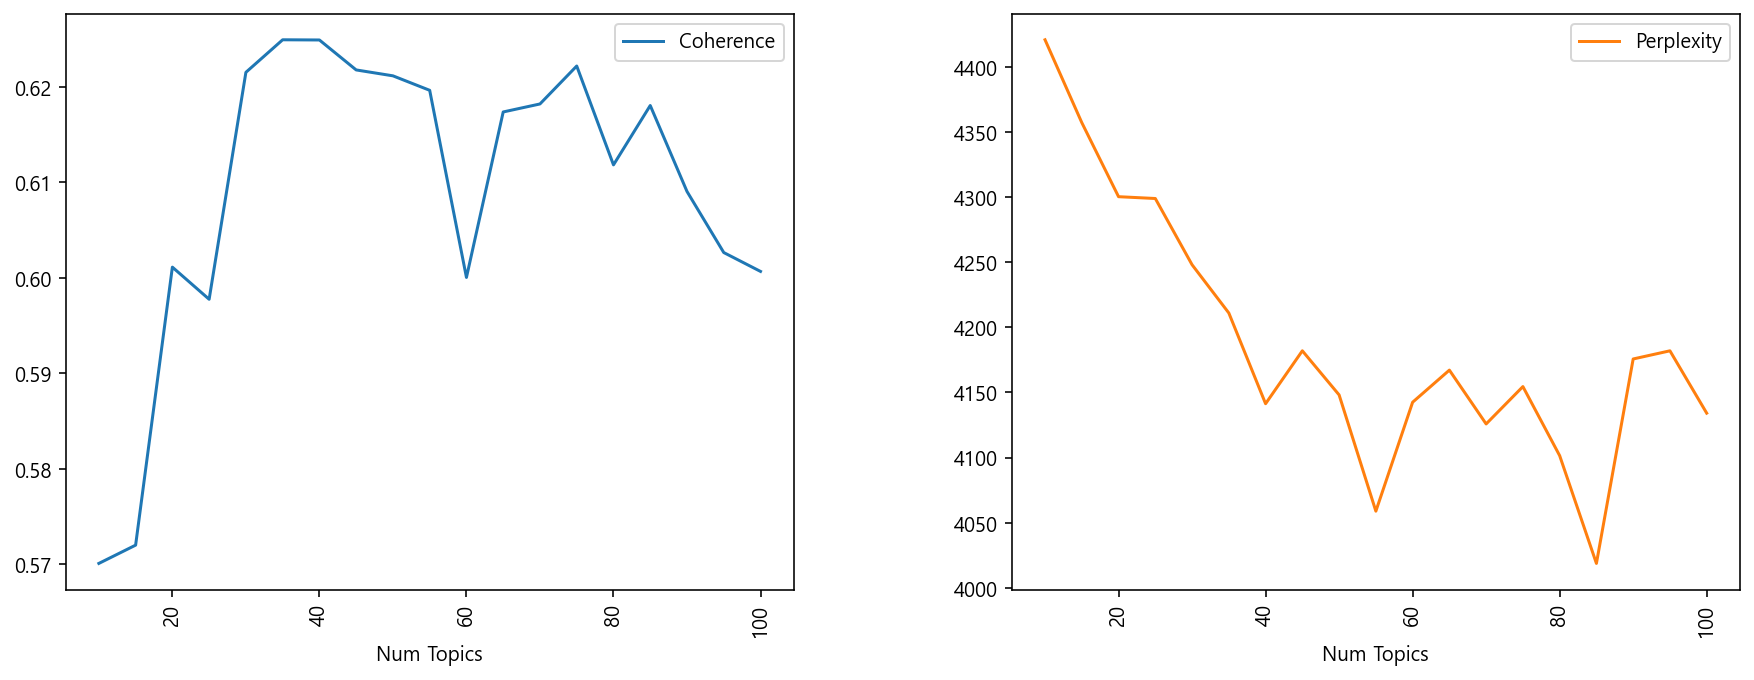

In [10]:
coherence_values = []
perplexities = []  

limit = 100 #마찬가지로 적당한 k를 찾기위해 10부터 100까지
start = 10
step = 5

compute_coherence_values(start, limit, step, 동아Content)

x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

=====10개짜리 토픽실행중... 실행중 포함 19 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.489860335963463	Perplexity: 4865.1865342114	Coherence: 0.5954877390451581
남은 예상시간 : 197.78820419311523초
=====15개짜리 토픽실행중... 실행중 포함 18 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.479931128235961	Perplexity: 4817.118122023116	Coherence: 0.6109642656287506
남은 예상시간 : 199.34457898139954초
=====20개짜리 토픽실행중... 실행중 포함 17 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.47836352030651	Perplexity: 4809.572685146449	Coherence: 0.6204338783631823
남은 예상시간 : 201.23152542114258초
=====25개짜리 토픽실행중... 실행중 포함 16 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.459762054712204	Perplexity: 4720.934539851127	Coherence: 0.6233884843381804
남은 예상시간 : 200.98934412002563초
=====30개짜리 토픽실행중... 실행중 포함 15 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.467621001699966	Perplexity: 4758.182286454496	Coherence: 0.6279083066732755
남은 예상시간 : 203.97021579742432초
=====35개짜리 토픽실행중... 실행중 포함 14 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.454775432420368	Perplex

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270A2CB3FD0>,
      dtype=object)

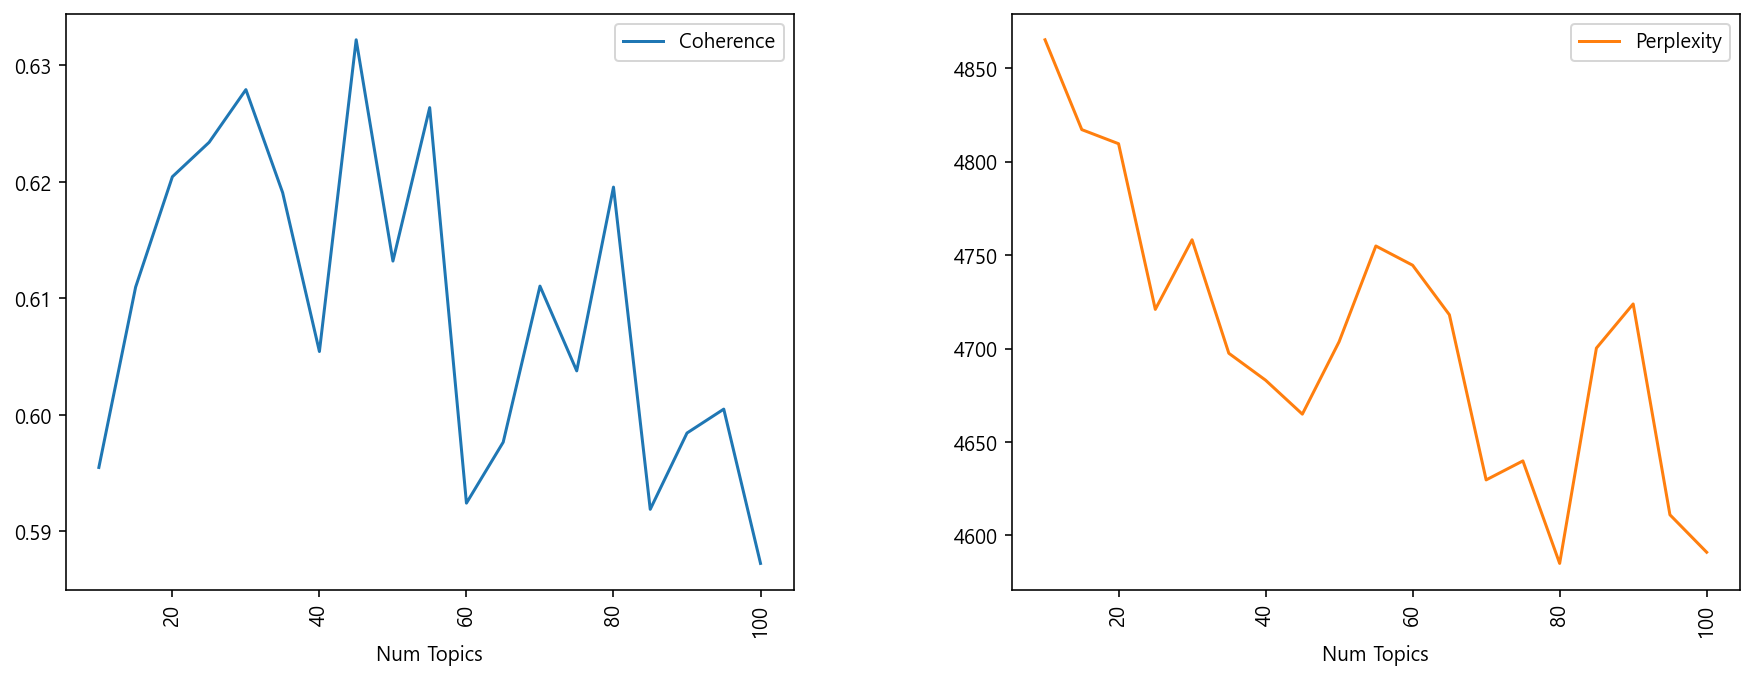

In [11]:
coherence_values = []
perplexities = []  

limit = 100 #마찬가지로 적당한 k를 찾기위해 10부터 100까지
start = 10
step = 5

compute_coherence_values(start, limit, step, 경향Content)
x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

* 적당한 k 값을 찾았으니, 최적의 k값 찾기
* 동아 40쯤
* 경향 45쯤

=====30개짜리 토픽실행중... 실행중 포함 11 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.33917478521115	Perplexity: 4184.6350934832335	Coherence: 0.6116531196519581
남은 예상시간 : 365.6468152999878초
=====32개짜리 토픽실행중... 실행중 포함 10 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.34301332170655	Perplexity: 4200.728836458468	Coherence: 0.6295173681248052
남은 예상시간 : 228.1396050453186초
=====34개짜리 토픽실행중... 실행중 포함 9 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.33902387517652	Perplexity: 4184.003637704073	Coherence: 0.6135629160151973
남은 예상시간 : 190.69659042358398초
=====36개짜리 토픽실행중... 실행중 포함 8 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.312046046220008	Perplexity: 4072.63726895502	Coherence: 0.6261435249239207
남은 예상시간 : 261.71310782432556초
=====38개짜리 토픽실행중... 실행중 포함 7 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.346791954902644	Perplexity: 4216.631876843802	Coherence: 0.6082141712941113
남은 예상시간 : 229.37224102020264초
=====40개짜리 토픽실행중... 실행중 포함 6 경우의 수 남음=====
Topic: 9448	Log-likelihood: -8.349435029090362	Perplexity: 4

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270A2CB3250>,
      dtype=object)

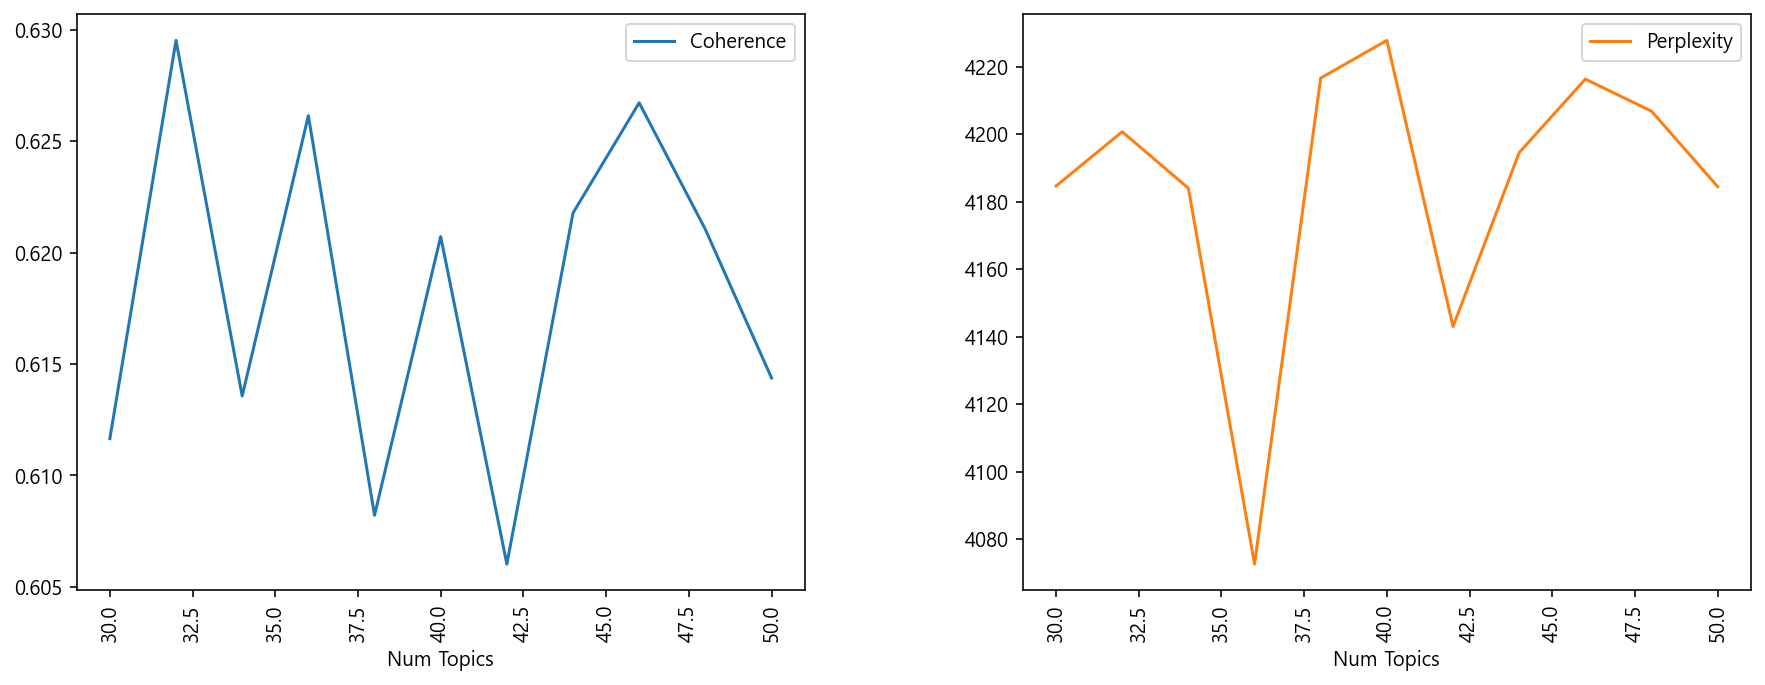

In [15]:
coherence_values = []
perplexities = []  

limit = 50 # 동아일보는 40쯤에서 최적의 값이 나왔으니, 30~50사이로
start = 30 
step = 2

compute_coherence_values(start, limit, step, 동아Content)

x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

=====34개짜리 토픽실행중... 실행중 포함 12 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.442901594017838	Perplexity: 4642.004675347957	Coherence: 0.6134362258894287
남은 예상시간 : 236.00969099998474초
=====36개짜리 토픽실행중... 실행중 포함 11 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.457397711414796	Perplexity: 4709.7858148145415	Coherence: 0.627208767491565
남은 예상시간 : 169.06254053115845초
=====38개짜리 토픽실행중... 실행중 포함 10 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.444770389341974	Perplexity: 4650.687742890816	Coherence: 0.6190820801626955
남은 예상시간 : 155.57470393180847초
=====40개짜리 토픽실행중... 실행중 포함 9 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.457332709156182	Perplexity: 4709.47967804889	Coherence: 0.6377471912792675
남은 예상시간 : 135.70759773254395초
=====42개짜리 토픽실행중... 실행중 포함 8 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.46102117714192	Perplexity: 4726.882518250156	Coherence: 0.6112444410382023
남은 예상시간 : 122.27767848968506초
=====44개짜리 토픽실행중... 실행중 포함 7 경우의 수 남음=====
Topic: 4461	Log-likelihood: -8.484507463058058	Perplexit

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027096AC88E0>,
      dtype=object)

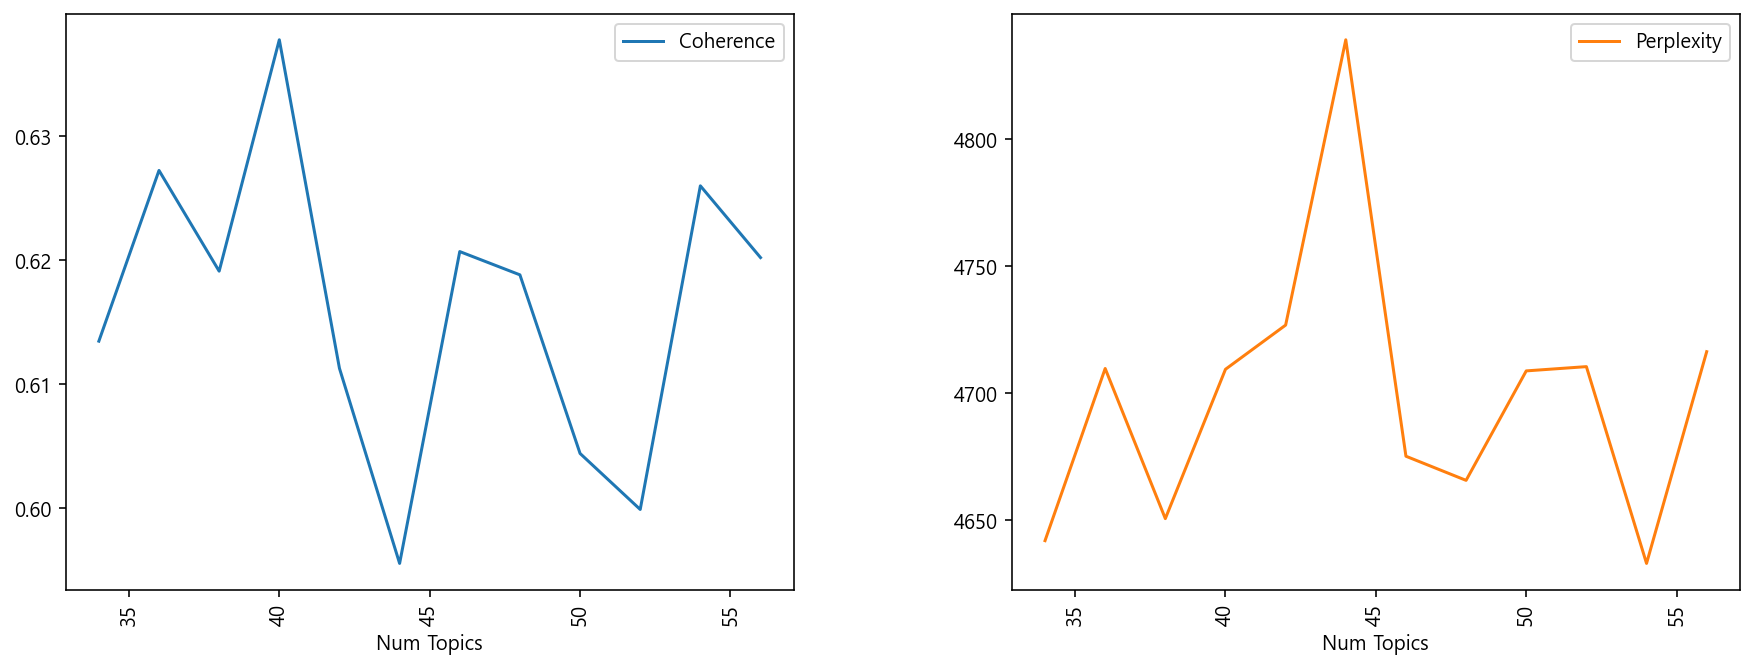

In [16]:
coherence_values = []
perplexities = []  

limit = 56 # 경향일보는 45에서 적당한 값이 나왔으니 35~55가 맞지만,
start = 34 # 짝수로 해야 그래프가 이쁘게 나오니 34~56으로 계산
step = 2

compute_coherence_values(start, limit, step, 경향Content)

x = range(start, limit+1, step)


mdl_check = pd.DataFrame(list(zip(x, perplexities, coherence_values)), columns=['Num Topics', 'Perplexity', 'Coherence'])

fig, ax = plt.subplots(figsize=(15,5), nrows=1, ncols=2)

plt.subplots_adjust(left=0.125,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.5)

pd.pivot_table(mdl_check, values=["Perplexity", "Coherence"],index="Num Topics").plot(kind='line', rot=90, ax=ax, subplots=True)

* perplexity는 낮을수록, coherence는 높을수록 일반적으로 우수하다고 평가함
* 동아 최적의 K값 -> 36
* 경향 최적의 K값 -> 40
* 동아

In [17]:
K =  36   #<< K입력

starttime = time.time()

mdl = tp.LDAModel(k=K, min_cf=500, rm_top=10)


x = len(동아Content)
for i in range(0,len(동아Content)): 
    mdl.add_doc(동아Content[i])

mdl.train(iter=100, workers=0) 
print(f'Iteration: {i+1}\tLog-likelihood: {mdl.ll_per_word}')

for k in range(mdl.k):
    print(f'Top 10 words of topic #{k}')
    print(mdl.get_topic_words(k, top_n=10))

runtime = time.time() - starttime
print(f"끝, {runtime}초걸림")


mdl.save(f'goodmodel_(k={K})_mdlresult(d).bin')
mdl = tp.LDAModel.load(f'goodmodel_(k={K})_mdlresult(d).bin')

Iteration: 9449	Log-likelihood: -6.6660436873453115
Top 10 words of topic #0
[('혁명', 0.03596886992454529), ('혁신', 0.03575717657804489), ('미래', 0.03038785420358181), ('성장', 0.026404164731502533), ('세계', 0.020245803520083427), ('스마트', 0.018109623342752457), ('생산', 0.01753227598965168), ('공장', 0.0169356856495142), ('경쟁력', 0.01489572785794735), ('경제', 0.014222157187759876)]
Top 10 words of topic #1
[('고객', 0.06552386283874512), ('상품', 0.04403320327401161), ('소비자', 0.023836836218833923), ('구매', 0.023108795285224915), ('매장', 0.019333774223923683), ('판매', 0.019252881407737732), ('온라인', 0.017419299110770226), ('쇼핑', 0.016691258177161217), ('결제', 0.016098041087388992), ('주문', 0.01585536077618599)]
Top 10 words of topic #2
[('클라우드', 0.06084142252802849), ('활용', 0.030783507972955704), ('분석', 0.027063468471169472), ('시스템', 0.0233992300927639), ('솔루션', 0.019028184935450554), ('관리', 0.019028184935450554), ('기반', 0.01845157891511917), ('구축', 0.01757737062871456), ('도입', 0.017372768372297287), ('정보', 

In [18]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,doc_topic_dists,doc_lengths,vocab,term_frequency,mds='mmds')

C:\Users\LEE\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, e

In [19]:
pyLDAvis.display(prepared_data)

* 경향

In [20]:
K =  40   #<< K입력

starttime = time.time()

mdl = tp.LDAModel(k=K, min_cf=500, rm_top=10)


x = len(경향Content)
for i in range(0,len(경향Content)): 
    mdl.add_doc(경향Content[i])

mdl.train(iter=100, workers=0) 
print(f'Iteration: {i+1}\tLog-likelihood: {mdl.ll_per_word}')

for k in range(mdl.k):
    print(f'Top 10 words of topic #{k}')
    print(mdl.get_topic_words(k, top_n=10))

runtime = time.time() - starttime
print(f"끝, {runtime}초걸림")


#mdl.save(f'goodmodel_(k={K})_mdlresult(k).bin')
mdl = tp.LDAModel.load(f'goodmodel_(k={K})_mdlresult(k).bin')

Iteration: 4462	Log-likelihood: -6.101333367966415
Top 10 words of topic #0
[('얼굴', 0.19887949526309967), ('사진', 0.15165364742279053), ('인식', 0.14461377263069153), ('카메라', 0.05925523862242699), ('감정', 0.04282885789871216), ('영상', 0.033149026334285736), ('모습', 0.029629087075591087), ('확인', 0.023469194769859314), ('영역', 0.020535912364721298), ('기능', 0.019362598657608032)]
Top 10 words of topic #1
[('의료', 0.1720481514930725), ('병원', 0.08460566401481628), ('환자', 0.053791314363479614), ('건강', 0.04446592181921005), ('치료', 0.0341944694519043), ('연구', 0.032302357256412506), ('대회', 0.03095085173845291), ('분야', 0.02608542889356613), ('의사', 0.024598771706223488), ('기기', 0.02149030566215515)]
Top 10 words of topic #2
[('교육', 0.20280855894088745), ('학생', 0.09442885220050812), ('대학', 0.08472321182489395), ('학교', 0.059346988797187805), ('직업', 0.030634455382823944), ('인재', 0.026084935292601585), ('평가', 0.023658521473407745), ('미래', 0.021232109516859055), ('학습', 0.020322205498814583), ('지원', 0.01890680

In [21]:
import pyLDAvis

topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq
prepared_data = pyLDAvis.prepare(topic_term_dists,doc_topic_dists,doc_lengths,vocab,term_frequency,mds='mmds')

C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
C:\Users\LEE\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py

In [22]:
pyLDAvis.display(prepared_data)